In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 河南資料整合

In [3]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河南1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河南2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河南3.xls')

patent_df = pd.concat([df1,df2,df3],ignore_index=True,sort=True)

In [3]:
patent_df.shape

(176856, 38)

In [4]:
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']

In [5]:
patent_df.shape

(176856, 38)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'41\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [8]:
patent_df_firm.shape

(6874, 38)

In [9]:
firm_gd.shape

(16914, 6)

In [10]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [11]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\河南_廠商.xlsx')

# 非模糊比對

In [12]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(2023, 45)
(21765, 45)


In [13]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(3433, 50)
(14785, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [14]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\河南_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(790, 44)
(18416, 44)
(1797, 49)
(18416, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\河南_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', 'CPC', 'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）',
       '专利类型', '中国申请人区县', '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日',
       '发明人', '合享价值度', '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数',
       '文献页数', '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码',
       '申请人类型', '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)',
       '被引证次数', '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '郑州',
       '洛陽', '安陽', '南陽', '新鄉', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','郑州','洛陽','安陽','南陽','新鄉','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(6995, 57)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\河南_結果.xlsx')

# 模糊比對

In [15]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(2248, 45)
(21420, 45)


In [16]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(3400, 50)
(14561, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\河南_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\河南_結果.xlsx',index_col=0)

In [4]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\河南_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(6995, 57)

In [5]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [6]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(18416, 57)
(202, 57)


In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\河南_結果.xlsx')

# 作圖

In [8]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [9]:
patent_count.sort_values()

申请人2
河南五一化工有限公司         1
潘子美                1
潘子恒                1
潘子叶                1
潘娅                 1
                ... 
河南中烟工业有限责任公司    1236
河南理工大学          1305
国家电网公司          1403
郑州大学            1567
河南科技大学          2717
Name: 專利數, Length: 49599, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\河南_結果.xlsx',index_col=0)
target1 = (34.81189,113.56691)
merge_df['郑州'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (34.62107,112.38383)
merge_df['洛陽'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (36.06895,114.36412)
merge_df['安陽'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (32.99066,112.5283)
merge_df['南陽'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (35.28208,113.89946)
merge_df['新鄉'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\河南_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (34.81189,113.56691)
target2 = (34.62107,112.38383)
target3 = (36.06895,114.36412)
target4 = (32.99066,112.5283)
target5 = (35.28208,113.89946)

for i in merge_df[merge_df['郑州']==''].index:
    merge_df.loc[i,'郑州'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'洛陽'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'安陽'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'南陽'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'新鄉'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [11]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['郑州']<10)or(x['洛陽']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['安陽']<10)or(x['南陽']<10)or(x['新鄉']<10)) else 0,axis=1)

In [15]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\河南_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(18416, 57)
0.7915942658557776
0.006678974804517811


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       14578
1.0         774
2.0         458
3.0         299
4.0         199
5.0         156
6.0         168
7.0         162
8.0         154
9.0         129
10.0        100
11.0         76
12.0         76
13.0         69
14.0         71
15.0         56
16.0         54
17.0         56
18.0         35
19.0         31
20.0         41
21.0         38
22.0         22
23.0         26
24.0         24
25.0         16
26.0         16
27.0         19
28.0         18
29.0         22
30.0         17
31.0         15
32.0         19
33.0         14
34.0         17
35.0         11
36.0          7
37.0         10
38.0          9
39.0          8
40.0         10
41.0          5
42.0          9
43.0         13
44.0          6
45.0          5
46.0         10
47.0          1
48.0          7
49.0          3
50.0          7
51.0         10
52.0          6
53.0          8
54.0          7
55.0          9
56.0          5
57.0          3
58.0          3
59.0          3
60.0          4
61.0          5
62.0

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0      170
1.0       12
2.0        3
3.0        2
4.0        3
8.0        3
10.0       2
11.0       1
15.0       1
17.0       1
22.0       1
26.0       1
31.0       1
260.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

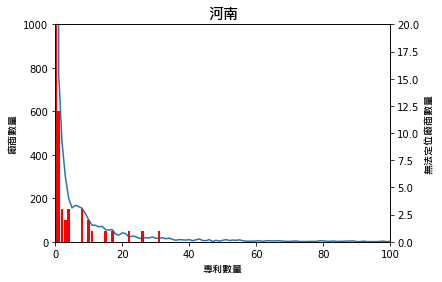

In [18]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('河南',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,1000])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\河南_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1417
0.0781448188385816
50


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1      305
2      189
3      134
4       75
5       63
6       57
7       64
8       36
9       46
10      43
11      22
12      27
13      30
14      19
15      15
16      17
17      13
18      11
19       2
20      11
21       7
22       9
23       8
24       7
25       4
26       3
27       7
28       8
29       5
30       3
31       6
32      12
33       3
34       7
35       6
36       4
37       4
38       4
39       1
40       6
41       2
42       5
43       3
44       3
45       2
46       5
48       2
50       5
51       2
52       1
53       3
54       3
55       4
58       1
59       2
60       2
63       2
64       1
65       4
67       3
68       1
70       1
71       1
72       2
73       1
74       2
76       1
78       1
79       2
81       1
82       1
87       2
90       1
96       1
99       1
102      2
103      1
107      1
112      2
122      2
123      1
125      1
129      1
131      1
134      1
142      1
145      1
147      1
151      1
152      1
153   

In [4]:
not_merge[not_merge['專利數']>=500].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,申请人省市代码,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,郑州,洛陽,安陽,南陽,新鄉,早期園區,近期園區,專利數,name_clean
18169,,,,,,,,G01R31/00,CN103033701B; CN103033701A,2,,发明授权,[许昌],[许昌],,CN,CN103033701B,2017-11-07 00:00:00,姚为正; 刘刚; 孙健; 姚钊; 夏克鹏; 李海鲲,9,CN,,1058,CN102170110A; CN102323546A; CN102323545A; CN102780409A; US20110141773A1,"<text>Khatir MOHAMED et al..Performance Analysis of a Voltage Source Converter (VSC) based HVDC Transmission System under Faulted Conditions.《Leonardo Journal of Sciences》.2009, 33-46.</text><text...",...,河南; 41,企业,CN201210507352.7,2012-11-30 00:00:00,CN103033701B; CN103033701A,2,,,0,到incoPat中查看\r\nCN103033701B,许继电气股份有限公司,许继电气股份有限公司,河南省许昌市许继大道1298号,1,34.0236,113.806,90.162269,146.710627,232.551982,164.984391,139.867544,0,0,535,许继电气
17608,,,,,,,,G01J5/00,CN102353455B; CN102353455A,2,0,发明授权,[二七],[郑州],,CN,CN102353455B,2013-04-17 00:00:00,杜利民; 孙明浩; 黄敬尧; 汪芳宗; 秦旷; 李璐; 李群才; 谢伟; 闫东,8,CN,,11402,US20030137318A1; CN101604835A; CN201765696U,"<text>孙卉.应用红外热成像技术诊断电气设备故障.《石油和化工设备》.2009, 37-40.</text>",...,河南; 41,企业,CN201110179965.8,2011-06-30 00:00:00,CN102353455B,1,,,0,到incoPat中查看\r\nCN102353455B,河南省电力公司郑州供电公司,河南省电力公司郑州供电公司,河南省郑州市淮河路9号,1,34.7289,113.653,12.136987,116.957352,162.090651,219.111267,65.353521,0,0,568,河南省电力郑州供电
18173,,,,,,,,E04G21/00; E04G13/02; E04G21/02,CN103015717A; CN103015717B,2,0,发明授权,,[郑州],,CN,CN103015717B,2016-01-06 00:00:00,张中善; 周申彬; 张鹏; 田鹏; 邢亚飞; 侯振国,9,CN,,9584,CN10212310A; CN101144328A; CN101956458A,,...,河南; 41,企业,CN201210503566.7,2012-12-01 00:00:00,CN103015717A; CN103015717B,2,,,0,到incoPat中查看\r\nCN103015717B,中国建筑第七工程局有限公司,中国建筑第七工程局有限公司,河南省郑州市城东路108号,1,34.7565,113.69,12.856753,120.656361,157.945432,223.433793,61.347803,0,0,654,中国建筑第七工程局
18214,,,,,,,,G01N30/02; G01N30/60,CN102967675B; CN102967675A,2,,发明授权,[中原],[郑州],,CN,CN102967675B,2013-10-16 00:00:00,刘绍锋; 刘惠民; 谢复炜; 张晓兵,9,CN,,58566,,,...,河南; 41,企业,CN201210548355.5,2012-12-18 00:00:00,CN102967675B; CN102967675A,2,,,0,到incoPat中查看\r\nCN102967675B,中国烟草总公司郑州烟草研究院,中国烟草总公司郑州烟草研究院,河南省郑州市高新区枫杨街2号,1,34.8143,113.567,0.267887,110.459540,156.898864,223.921590,60.119256,1,0,658,中国烟草总郑州烟草研究院


Text(0.5, 0, '專利數量')

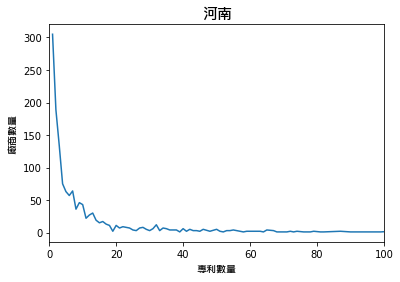

In [5]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('河南',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [6]:
cleaned.to_excel(r'E:\paper\名稱merge\河南_結果.xlsx')

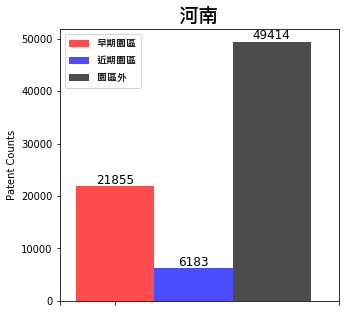

In [8]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('河南',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

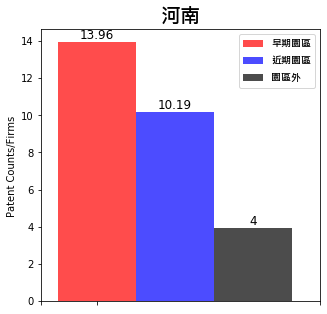

In [9]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('河南',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)